In [1]:
import mlrun
import os
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
import mlrun
mlrun.set_env_from_file("env.var")

In [3]:
# Set the base project name
project_name = 'sagemaker-payment'

In [4]:
project = mlrun.get_or_create_project(name="sagemaker",
                                      user_project=True,
                                      context="./")

> 2024-01-24 14:54:25,603 [info] Project loaded successfully: {'project_name': 'sagemaker'}


In [5]:
# Getting our model training function
train = project.set_function('./src/train.py', requirements=['sagemaker'],
                     name='train', kind='job', image='mlrun/mlrun')

In [6]:
evaluate_function = project.set_function(
    "src/evaluate.py",
    "evaluate",
    handler="evaluate",
    image="mlrun/mlrun",
    requirements=["xgboost"],
)

In [7]:
# Serving
serving_function = project.set_function(
    func="src/serving.py",
    name="serving",
    kind="serving",
    image="mlrun/mlrun",
    requirements=["xgboost"],
)

In [8]:
project.build_function("train")

> 2024-01-24 14:54:25,893 [info] Started building image: .mlrun/func-sagemaker-admin-train:latest


The `overwrite_build_params` parameter default will change from 'False' to 'True' in 1.8.0.


INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc22 
INFO[0000] Retrieving image mlrun/mlrun:1.6.0-rc22 from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc22 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'mlrun/mlrun:1.6.0-rc22' [idx: '0', base-idx: '-1'] 
INFO[0000] Unpacking rootfs as cmd RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt requires it. 
INFO[0040] ARG AWS_ACCESS_KEY_ID=$AWS_ACCESS_KEY_ID     
INFO[0040] ARG AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION   
INFO[0040] ARG AWS_SECRET_ACCESS_KEY=$AWS_SECRET_ACCESS_KEY 
INFO[0040] ARG SAGEMAKER-ROLE=$SAGEMAKER-ROLE           
INFO[0040] RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt 
INFO[0040] Initializing snapshotter ...                 
INFO[0040] Taking snapshot of full files

BuildStatus(ready=True, outputs={'image': '.mlrun/func-sagemaker-admin-train:latest'})

In [9]:
project.build_function("evaluate")

The `overwrite_build_params` parameter default will change from 'False' to 'True' in 1.8.0.


> 2024-01-24 14:56:24,075 [info] Started building image: .mlrun/func-sagemaker-admin-evaluate:latest
INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc22 
INFO[0000] Retrieving image mlrun/mlrun:1.6.0-rc22 from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc22 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'mlrun/mlrun:1.6.0-rc22' [idx: '0', base-idx: '-1'] 
INFO[0000] Unpacking rootfs as cmd RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt requires it. 
INFO[0036] ARG AWS_ACCESS_KEY_ID=$AWS_ACCESS_KEY_ID     
INFO[0036] ARG AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION   
INFO[0036] ARG AWS_SECRET_ACCESS_KEY=$AWS_SECRET_ACCESS_KEY 
INFO[0036] ARG SAGEMAKER-ROLE=$SAGEMAKER-ROLE           
INFO[0036] RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.t

BuildStatus(ready=True, outputs={'image': '.mlrun/func-sagemaker-admin-evaluate:latest'})

In [10]:
%%writefile src/workflow.py
import mlrun
from kfp import dsl
from mlrun import get_or_create_ctx


@dsl.pipeline(
    name="Fraud Detection Pipeline",
    description="Detecting fraud from a transactions dataset"
)
def kfpipeline(evaluate_path):
    project = mlrun.get_current_project()

    train_function = project.get_function('train', sync=True)
    train_run = project.run_function(
        function=train_function,
        name='train',
        handler='train',
        params={},
        outputs=["model_path"],
    )

    ctx = get_or_create_ctx("kfp")
    ctx.logger.info(train_run.outputs)

    # evaluating the model
    evaluate_function = project.get_function("evaluate")

    # running
    evaluate_run = project.run_function(
        evaluate_function,
        handler="evaluate",
        params={
            "model_path": train_run.outputs['model_path'],
            "model_name": "xgboost-model",
            "test_set": evaluate_path,
            "label_column": "transaction_category",
        },
        returns=["classification_report: dataset"]
    )

    # # deploying serving function
    # serving_function = project.get_function("serving")

    # if serving_function.spec.graph is None:
    #     # Set the topology and get the graph object:
    #     graph = serving_function.set_topology("flow", engine="async")

    #     # Add the steps:
    #     graph.to("XGBModelServer",
    #              name="xgboost-model",
    #              model_path= train_run.outputs['model_path'])\
    #     .to(handler="postprocess", name="postprocess").respond()
               

    # # Set the desired requirements:

    # # Deploy the serving function:
    # project.deploy_function("serving").after(train_run)


Overwriting src/workflow.py


In [11]:
workflow_name = "workflow"
project.set_workflow(name=workflow_name, workflow_path="src/workflow.py")

In [12]:
s3_data = "s3://{}/{}/test/test.csv".format("sagemaker-us-east-2-934638699319", "payment-classification")

In [13]:
#project.run(workflow_name ,watch = True ,local = True, arguments={"evaluate_path": s3_data})

### 1. Run the pipeline remotely <a class="anchor" id="Setup"></a>

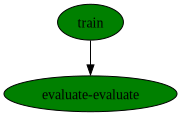

uid,start,state,name,parameters,results
...7dcff03b,Jan 24 15:05:25,completed,evaluate-evaluate,model_path=store://artifacts/sagemaker-admin/train_model_path@703220cf-d4f6-4201-bd8c-fc2a53bf689bmodel_name=xgboost-modeltest_set=s3://sagemaker-us-east-2-934638699319/payment-classification/test/test.csvlabel_column=transaction_category,
...0ab29451,Jan 24 14:58:26,completed,train,,


703220cf-d4f6-4201-bd8c-fc2a53bf689b

In [14]:
project.run(workflow_name,         
            watch=True,arguments={"evaluate_path": s3_data})